# Implementation of object detection

Author: Mingjie Ye

## Introduction
In this report, I'm going to introduce a brief description of the FAST, BRIEF and ORB and their implementations to images. During the implementations parts, I compute the keypoints of images and compare the keypoints between two images to find matches. The result will be showed below so that we could use the matches to find a general mapping between the images and align other images in the future.

## FAST
FAST (Features from Accelerated Segment Test) is a common cornor detector and basically can be divided to two steps: Feature Detection and Machine Learning.

### Feature Detection
According to the [OpenCV tutorial](https://docs.opencv.org/3.4/df/d0c/tutorial_py_fast.html), the steps are:

1. Select a pixel $p$ in the image which is to be identified as an interest point or not. Let its intensity be $I_p$.
2. Select appropriate threshold value $t$.
3. Consider a circle of 16 pixels around the pixel under test.

![](./for_report/fast1.jpg)

4. If there are $n$ contiguous pixels in the circle (of 16 pixels) which are all brighter than $I_p+t$, or all darker than $I_p−t$, we consider this interest point is a cornor. Here, n was chosen to be 12.
5. A high-speed test was proposed to exclude a large number of non-corners.

### Machine Learning

1. Select a set of images for training.
2. Run FAST algorithm for every images to find feature points.
3. For each feature point, store the 16 pixels around it as a vector. Same for all the images and finally get feature vector $P$.
4. According to the state of luminance (brighter, darker or similar), $P$ could be subdivided into 3 groups: $P_b$, $P_d$ and $P_s$.
5. Define a new boolean label, $K_p$, which is true if $p$ is a corner and false otherwise.
6. Then use ID3 (one decision tree classifier algorithm) to train with the labels $K_p$. It selects the x which yields the most information about whether the candidate pixel is a corner, measured by the entropy of $K_p$.
7. This is recursively applied to all the groups until its entropy is zero.
8. So, the final decision tree is used for FAST detection in other images.

### Non-maximal Suppression

There is a weakness in the feature dection part: multiple features are detected adjacent to one another. It could be solved by using Non-maximum Suppression.

Compute a score function, $V$ for all the detected feature points. $V$ is the sum of absolute difference between $p$ and 16 surrounding pixels values. Consider two adjacent keypoints and compute their $V$ values. Discard the one with lower $V$ value.


### Implementation
Firstly, I input an image as input and show it here.

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

file='img1.jpg'
file2='img2.jpg'
fast_true='./output/fast_true_'
fast_false='./output/fast_false_'

img = cv2.imread('input/'+file,0)
img2 = cv2.imread('input/'+file2,0)

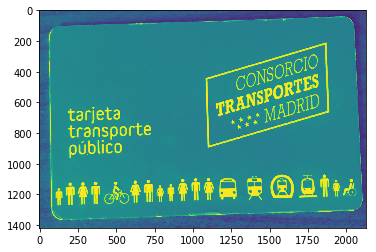

In [2]:
plt.imshow(img) 
plt.show()  # display the input image one

Secondly, we are going to use FAST binary descriper to do a corner dection. It's defined in FastFeatureDetector_create in OpenCV-Python, and I set the threshold to 8. Non-maximum Suppression is used in this time and the keypoints will be found and showed below. You can find the output image with keypoints in "./fast_true".

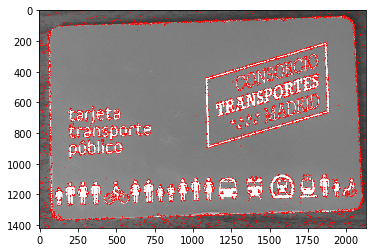

Threshold:  8
nonmaxSuppression:  True
neighborhood:  2
Total Keypoints with nonmaxSuppression:  11595


True

In [3]:
# Initiate FAST object with default values
fast = cv2.FastFeatureDetector_create(threshold=8)

# find and draw the keypoints
kp = fast.detect(img,None)
out_img2 = cv2.drawKeypoints(img, kp, None,color=(255,0,0))

plt.imshow(out_img2) 
plt.show()  # display it

print("Threshold: ", fast.getThreshold())
print("nonmaxSuppression: ", fast.getNonmaxSuppression())
print("neighborhood: ", fast.getType())
print("Total Keypoints with nonmaxSuppression: ", len(kp))

cv2.imwrite(fast_true+file,out_img2)

Then, in order to check the performance of Non-maximum Suppression, I use FAST again to the same image but without Non-maximum Suppression as a contrast. The output images are saved in "./fast_false".

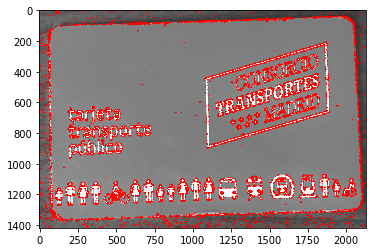

Threshold:  8
nonmaxSuppression:  False
neighborhood:  2
Total Keypoints without nonmaxSuppression:  47599


True

In [4]:
# Disable nonmaxSuppression
fast.setNonmaxSuppression(0)
kp = fast.detect(img,None)

out_img3 = cv2.drawKeypoints(img, kp, None, color=(255,0,0))

plt.imshow(out_img3) 
plt.show()  # display it

print("Threshold: ", fast.getThreshold())
print("nonmaxSuppression: ", fast.getNonmaxSuppression())
print("neighborhood: ", fast.getType())
print("Total Keypoints without nonmaxSuppression: ", len(kp))


cv2.imwrite(fast_false+file,out_img3)

We can see the differences between these two output. We get more keypoints without Non-maximum Suppression but that's too much for this cornor, which means it is not clear to line the cornor, the outline of cornor is blurred. The number is 47599 without Non-maximum Suppression and 11595 with Non-maximum Suppression. Comparing with the outputs, we could find the output with Non-maximum Suppression is much better. 

## BRIEF

According to the [document of BRIEF](https://docs.opencv.org/3.4/dc/d7d/tutorial_py_brief.html), BRIEF (Binary Robust Independent Elementary Features) provides a shortcut to find binary strings directly without finding descriptors. It takes smoothened image patch and selects a set of $n_d(x,y)$ location pairs in an unique way. Then some pixel intensity comparisons are done on these location pairs. For example, let first location pairs be $p$ and $q$. If $I(p)<I(q)$, then its result is 1, else it is 0. This is applied for all the $n_d$ location pairs to get a $n_d$-dimensional bitstring. According to the document [xfeatures2d](https://github.com/opencv/opencv_contrib/blob/master/modules/xfeatures2d/include/opencv2/xfeatures2d.hpp#L125), $n_d$ can be 16, 32 (by default) or 64. Here, we set the $n_d$ to 64.

BRIEF is a feature descriptor, it doesn't provide any method to find the features. So we will use other feature detectors like SIFT, SURF, CenSurE etc. Here, I use FAST detector used before and get the descriptors.

The code is a computation of BRIEF descriptors with the help of CenSurE detector.

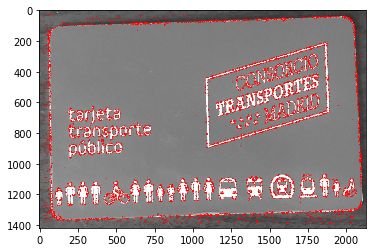

Total Keypoints with nonmaxSuppression:  11091
64
(11091, 64)


In [5]:
# Initiate BRIEF extractor
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create(64,)
fast.setNonmaxSuppression(1)
# find the keypoints with FAST
kp = fast.detect(img,None)
# compute the descriptors with BRIEF
kp, des = brief.compute(img, kp)
out_img4 = cv2.drawKeypoints(img, kp, None, color=(255,0,0))
plt.imshow(out_img4) 
plt.show()  # display it

cv2.imwrite('./output/BRIEF_'+file,out_img4)
print("Total Keypoints with nonmaxSuppression: ", len(kp))
print( brief.descriptorSize() )
print( des.shape )

## ORB

According to the [document of ORB](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html). ORB (Oriented FAST and Rotated BRIEF) is also a good alternative to SIFT and SURF in computation cost, matching performance and patents. Just like its name, ORB is basically a fusion of FAST and BRIEF with many modifications to enhance the performance.

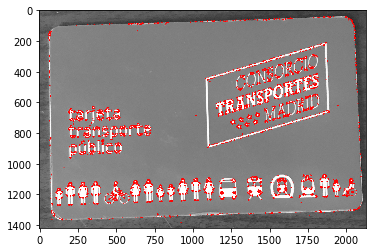

In [6]:
# Initiate ORB detector
orb = cv2.ORB_create(30000,)
# find the keypoints with ORB
kp = orb.detect(img,None)
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
out_img5 = cv2.drawKeypoints(img, kp, None, color=(255,0,0), flags=0)
cv2.imwrite('./output/ORB_'+file,out_img5)
plt.imshow(out_img5)
plt.show()

## Feature Matching
Now, I'm going to match features of the img to another image by the ORB descriptor defined before. The matching method I used is Brute-Force matcher which is pretty simple. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. And the closest one is returned. Consider we are going to use the binary string based descriptor ORB, we shall use Hamming distance as measurement. Let's show the compared image first.

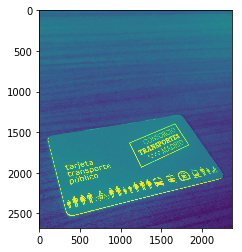

In [7]:
plt.imshow(img2) 
plt.show()  # display the second image
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img,None)
kp2, des2 = orb.detectAndCompute(img2,None)

Then, create BF Matcher object and match the descriptors and draw the most similar 30 keypoints and their matching lines in the two images.

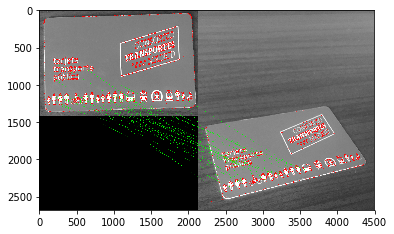

In [8]:
# create BFMatcher object using Hamming distance
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 30 matches.
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = cv2.DrawMatchesFlags_DEFAULT)
out_img6 = cv2.drawMatches(img,kp1,img2,kp2,matches[:30],None,**draw_params)

cv2.imwrite('./output/matching.jpg',out_img6)
plt.imshow(out_img6)
plt.show()

We can see the matching is good in general. The strongest parts are mainly the words "tarjeta transporte público" and the icon at the bottom. Therefore, we could find the transformation matrix and use it to transform the keypoints of first image to corresponding points in the other image.